# Multi-class leaf disease classifier using PlantVillage dataset and transfer learning (EfficientNetB0)
## We have used JupyterNotebook running on GoogleColab leveraging GPU for this project

In [ ]:
# ----------------------------------------
# ✅ BLOCK 1: SETUP & LOAD DATASET
# ----------------------------------------

# ✅ Import standard Python libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For image processing

# ✅ TensorFlow and Keras imports
import tensorflow as tf
import tensorflow_hub as hub  # Optional: for using models from TF Hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ✅ Sklearn utilities for metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  # For heatmaps (used during evaluation)

# 🔍 Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 1


In [ ]:
# 🧪 Install TensorFlow Datasets (TFDS) to access PlantVillage dataset
!pip install -q tensorflow-datasets

# ✅ Import TFDS after installation
import tensorflow_datasets as tfds
from pprint import pprint  # For pretty-printing dictionary data

# 🔧 Print safety info again (helpful for reproducibility)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
AUTOTUNE = tf.data.AUTOTUNE  # Let TF decide how many threads to use

# 🔽 LOAD THE PLANTVILLAGE DATASET FROM TFDS
# Splitting 'train' split into 80% train, 10% val, 10% test
try:
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80:90%]', 'train[90%:]'],
        with_info=True,         # Load metadata like class names, count, etc.
        as_supervised=True,     # Get (image, label) pairs
        shuffle_files=True      # Shuffle underlying TFRecord files
    )
except Exception as e:
    print("Error loading PlantVillage from TFDS:", e)
    raise

# 🧠 Print key dataset metadata
print("\nDataset builder info summary:")
pprint({
    'dataset_name': ds_info.name,
    'description': ds_info.description[:300] + '...' if ds_info.description else None,
    'num_classes': ds_info.features['label'].num_classes,
    'class_names_sample': ds_info.features['label'].names[:10],
    'num_examples (train split)': ds_info.splits['train'].num_examples
})

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.838XCJ_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.

Dataset builder info summary:
{'class_names_sample': ['Apple___Apple_scab',
                        'Apple___Black_rot',
                        'Apple___Cedar_apple_rust',
                        'Apple___healthy',
                        'Blueberry___healthy',
                        'Cherry___healthy',
                        'Cherry___Powdery_mildew',
                        'Corn___Cercospora_leaf_spot Gray_leaf_spot',
                        'Corn___Common_rust',
                        'Corn___healthy'],
 'dataset_name': 'plant_village',
 'description': 'The PlantVillage dataset consists of 54303 healthy and '
                'unhealthy leaf images\n'
                'divided into 38 categories by species and disease.\n'
                '\n'
                'NOTE: The original dataset is not available from the original '
                'source\

IMG_SIZE=224, BATCH_SIZE=32, NUM_CLASSES=38

Example class names (first 30):
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight']

Counting examples in train/val/test splits...

Sample per-class distribution (first 20):
00 Apple___Apple_scab                        

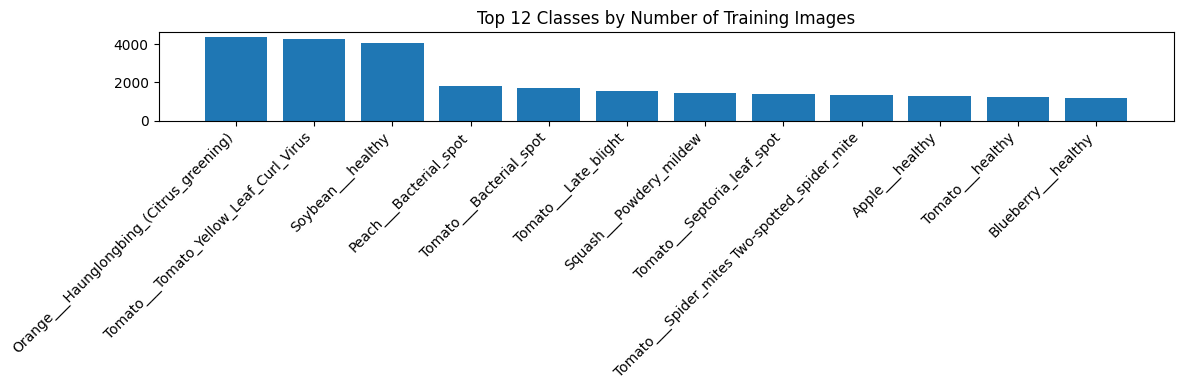

In [ ]:
# ----------------------------------------
# ✅ BLOCK 2: CONFIGURATION + CLASS DISTRIBUTION
# ----------------------------------------

# 🧮 Define constants used across the training pipeline
IMG_SIZE = 224             # Input image size expected by EfficientNetB0
BATCH_SIZE = 32            # Number of images per training batch
EPOCHS = 12                # Total epochs for training
AUTO = tf.data.AUTOTUNE    # Automatic parallel thread usage
LR = 1e-3                  # Initial learning rate

# 📦 Get number of classes from dataset info
NUM_CLASSES = ds_info.features['label'].num_classes
print(f"IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}, NUM_CLASSES={NUM_CLASSES}")

# 🔡 Get class names from dataset info
class_names = ds_info.features['label'].names
print("\nExample class names (first 30):")
print(class_names[:30])  # print first 30 class names for preview

# 🧮 Count samples per class — useful for checking class imbalance
def get_label_counts(dataset, num_classes=None):
    """
    Counts the number of examples for each class in a TF dataset.
    - dataset: a tf.data.Dataset of (image, label) pairs
    - num_classes: total number of classes (inferred if not passed)
    Returns:
        numpy array of counts for each label index
    """
    if num_classes is None:
        num_classes = NUM_CLASSES
    counts = np.zeros(num_classes, dtype=int)

    # ⚠️ Looping eagerly over dataset (takes time but accurate)
    for _, label in dataset:
        counts[int(label.numpy())] += 1
    return counts

# 📊 Count examples in train / val / test datasets
print("\nCounting examples in train/val/test splits...")
train_counts = get_label_counts(ds_train)
val_counts = get_label_counts(ds_val)
test_counts = get_label_counts(ds_test)

# 🔎 Print sample label-wise stats for the first 20 classes
print("\nSample per-class distribution (first 20):")
for i, cname in enumerate(class_names):
    if i < 20:   # Limit output to 20 for readability
        print(f"{i:02d} {cname:45s}: train={train_counts[i]:5d}, val={val_counts[i]:5d}, test={test_counts[i]:5d}")
    else:
        break

# 🧾 Print total examples in each split
print("\nTOTAL EXAMPLES ➜")
print("Train:", train_counts.sum())
print("Val  :", val_counts.sum())
print("Test :", test_counts.sum())

# 📊 Bar plot: Top-K most represented classes in train split
top_k = 12  # Only show top 12 for clarity
indices = np.argsort(-train_counts)[:top_k]  # Sort descending

plt.figure(figsize=(12, 4))
plt.bar([class_names[i] for i in indices], train_counts[indices])
plt.xticks(rotation=45, ha='right')
plt.title("Top 12 Classes by Number of Training Images")
plt.tight_layout()
plt.show()

If we analyze the above statistics, we will realize that some class like Orange_Haunglongbing has more datapoints. This will lead to class imbalance in training ( We will see if model training further). We will also check how to fix it.

In [ ]:
# Cell 5 — Helper preprocessing & augmentation functions
# Preprocessing: resize + rescale to [0,1]
def preprocess_image(image, label, img_size=IMG_SIZE):
    # image: uint8 tensor (H,W,3). We resize and scale to float32 [0,1]
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Simple augmentation pipeline for training
def augment_image(image, label):
    # Random flip
    image = tf.image.random_flip_left_right(image)
    # Random flip up-down (optional for leaves)
    image = tf.image.random_flip_up_down(image)
    # Random brightness & contrast
    image = tf.image.random_brightness(image, max_delta=0.12)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Random rotation small angle (use tf.image.rot90 for multiples of 90,
    # but here we use a small rotation via tf.keras preprocessing layer later if desired)
    return image, label

In [ ]:
# ----------------------------------------
# ✅ BLOCK 3: PREPROCESSING & PIPELINES
# ----------------------------------------

# ✅ Preprocessing function — used for ALL datasets (train, val, test)
def preprocess_image(image, label, img_size=IMG_SIZE):
    """
    Prepares an image for the model:
    - Resizes to IMG_SIZE x IMG_SIZE
    - Converts pixels to float and rescales from [0, 255] → [0.0, 1.0]
    """
    image = tf.image.resize(image, [img_size, img_size])        # Resize image
    image = tf.cast(image, tf.float32) / 255.0                  # Normalize to [0,1]
    return image, label

# ✅ Data augmentation — applied ONLY to training images
def augment_image(image, label):
    """
    Randomly augment the image to help generalize:
    - Flip horizontally and vertically
    - Adjust brightness and contrast
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.12)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# ✅ Training pipeline builder
def prepare_for_training(ds, batch_size=BATCH_SIZE, shuffle_buffer=2048):
    """
    Prepares dataset with preprocessing, augmentation, batching and prefetching
    Used for: training dataset
    """
    ds = ds.map(preprocess_image, num_parallel_calls=AUTO)     # Resize + normalize
    ds = ds.shuffle(shuffle_buffer)                             # Shuffle images
    ds = ds.map(augment_image, num_parallel_calls=AUTO)        # Apply augmentation
    ds = ds.batch(batch_size)                                   # Batch images
    ds = ds.prefetch(AUTO)                                      # Improve pipeline performance
    return ds

# ✅ Validation / test pipeline builder
def prepare_for_evaluation(ds, batch_size=BATCH_SIZE):
    """
    Prepares dataset with only preprocessing, batching and prefetching
    Used for: validation and test datasets
    """
    ds = ds.map(preprocess_image, num_parallel_calls=AUTO)     # Resize + normalize
    ds = ds.batch(batch_size)                                   # Batch
    ds = ds.prefetch(AUTO)                                      # Speed-up
    return ds

# 🧪 Apply pipeline functions to the datasets
train_ds = prepare_for_training(ds_train)
val_ds   = prepare_for_evaluation(ds_val)
test_ds  = prepare_for_evaluation(ds_test)

# 🔍 Sanity check — get one batch and print shapes
for images, labels in train_ds.take(1):
    print("✅ Sample batch shape:")
    print("Images:", images.shape)   # Expected: (batch_size, IMG_SIZE, IMG_SIZE, 3)
    print("Labels:", labels.shape)   # Expected: (batch_size,)

✅ Sample batch shape:
Images: (32, 224, 224, 3)
Labels: (32,)


Question to ponder:

What is Augmentation? Why we only Augment Training data and not Validation and Test datasets?

What is AUTOTUNE? How it can help enhance preprocessing while leveraging GPU.

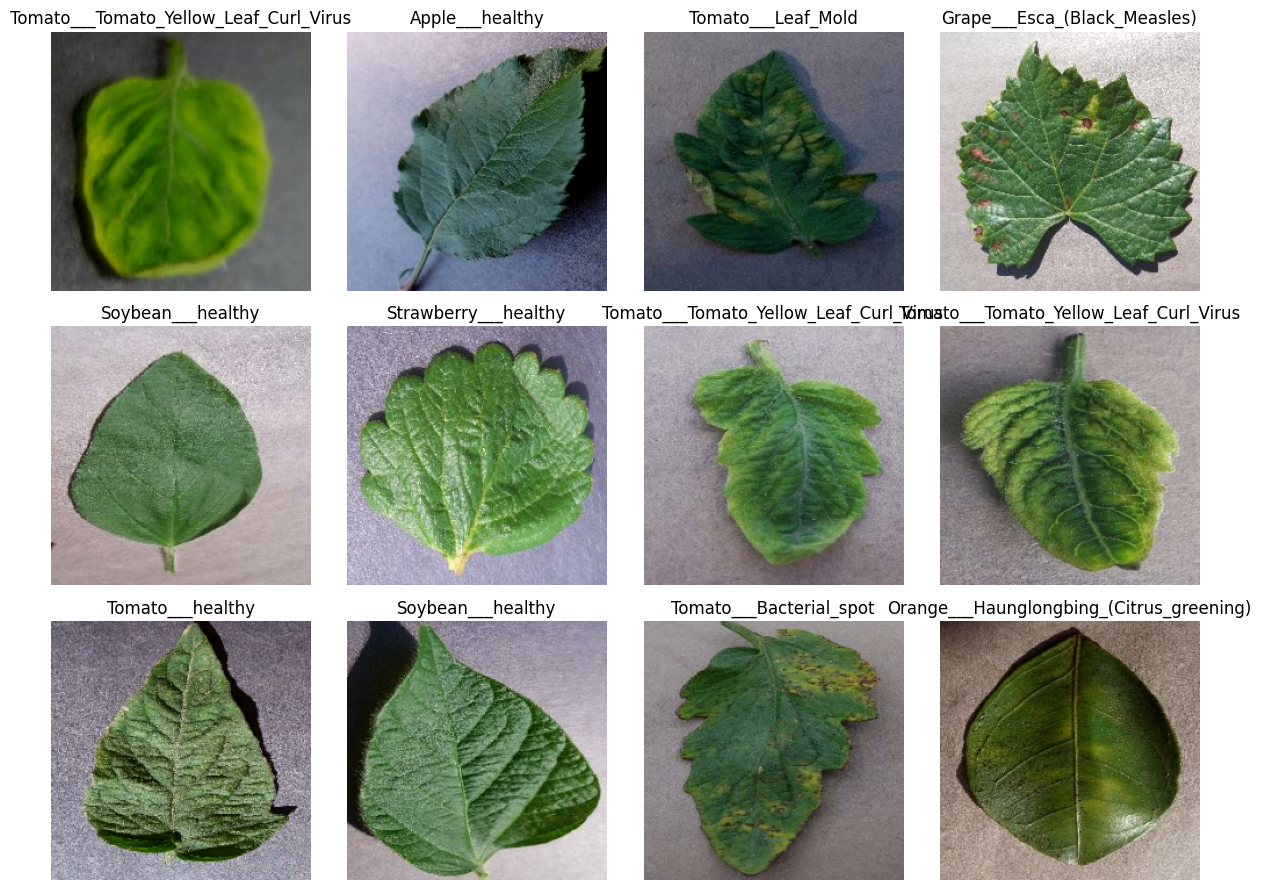

In [ ]:
# ----------------------------------------
# ✅ BLOCK 4: VISUALIZE SAMPLE IMAGES
# ----------------------------------------

# 📸 Function to show a grid of sample images with their class labels
def show_samples(dataset, class_names, rows=3, cols=4):
    """
    Displays a grid of (image, label) pairs from a batched tf.data.Dataset.
    Shows 'rows x cols' images using matplotlib.
    """
    plt.figure(figsize=(cols * 3, rows * 3))  # Adjust overall figure size
    i = 0
    for images, labels in dataset.unbatch().take(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)   # Create subplot
        plt.imshow(images.numpy())            # Show image (converted to numpy array)
        plt.title(class_names[int(labels.numpy())])  # Map label index to class name
        plt.axis('off')                       # Hide axes
        i += 1
    plt.tight_layout()
    plt.show()

# 🔍 Display a 3x4 grid (12 images) from the training dataset
# Remember: `train_ds` has both preprocessing + augmentation applied
show_samples(train_ds, class_names, rows=3, cols=4)

## Model Building

	- Why EfficientNetB0? It offers a compact, high-quality ImageNet pretrained backbone with good speed/accuracy tradeoff — suitable for Colab and beginner projects.
	- Why SparseCategoricalCrossentropy? Our TFDS pipeline yields integer labels, so sparse loss avoids one-hot conversion.
	- Two-stage training recommended
	  Stage 1: Freeze the base (base_trainable=False), train only the head (faster, prevents catastrophic forgetting).
	  Stage 2 (fine-tune): Unfreeze top N layers of the base (e.g., last 20–50 layers using unfreeze_model_top_layers) and recompile with a much smaller LR (1e-5 or 5e-6) and train for a few more epochs.
	- Dropout + BatchNorm in head helps regularization.
	- Top-3 accuracy metric is useful for multi-class recognition tasks where multiple leaf diseases can look similar.

In [ ]:
# ----------------------------------------
# ✅ BLOCK 5: BUILD TRANSFER LEARNING MODEL (EfficientNetB0)
# ----------------------------------------

# ✅ Imports (redundant if already done earlier — safe to re-import)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics

# 🧾 Safety check — make sure config values exist
if 'IMG_SIZE' not in globals() or 'NUM_CLASSES' not in globals():
    raise RuntimeError("IMG_SIZE and NUM_CLASSES must be defined.")

# 📐 Input shape expected by the model
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BASE_MODEL_NAME = "EfficientNetB0"
WEIGHTS = "imagenet"   # Load pretrained weights from ImageNet

# ⚙️ Optional: Enable mixed precision (for advanced students on modern GPUs)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

# ✅ Main function to build the model
def build_model(num_classes=NUM_CLASSES,
                input_shape=INPUT_SHAPE,
                dropout_rate=0.4,
                base_trainable=False):
    """
    Builds and compiles a transfer learning model using EfficientNetB0:
    - Includes preprocessing, base CNN, pooling, dropout, and Dense head.
    - Allows freezing or unfreezing the base CNN.
    """

    # 1️⃣ Input Layer
    inputs = layers.Input(shape=input_shape, name="input_image")

    # 2️⃣ Preprocessing Layer — scale [0,1] → [-1,1] as expected by EfficientNet
    x = layers.Rescaling(scale=2.0, offset=-1.0, name="rescale_to_neg1_1")(inputs)

    # 3️⃣ Load pretrained EfficientNetB0 (exclude top)
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,         # Exclude original classifier head
        weights=WEIGHTS,           # Load ImageNet weights
        input_shape=input_shape,
        pooling=None               # We'll add pooling ourselves
    )
    base_model.trainable = base_trainable  # Freeze for stage-1 training
    x = base_model(x, training=False)      # Run input through frozen base

    # 4️⃣ Classification Head
    x = layers.GlobalAveragePooling2D(name="gap")(x)                  # Spatial pooling
    x = layers.BatchNormalization(name="head_batchnorm")(x)          # Helps with fine-tuning stability
    x = layers.Dropout(rate=dropout_rate, name="head_dropout")(x)    # Regularization
    outputs = layers.Dense(num_classes, activation="softmax",        # Final softmax output
                           dtype="float32", name="predictions")(x)   # Force float32 for numeric stability

    # 🏗️ Build model object
    model = models.Model(inputs=inputs, outputs=outputs, name=f"{BASE_MODEL_NAME}_transfer")

    # 🛠️ Compile the model
    optimizer = optimizers.Adam(learning_rate=1e-3)
    loss = losses.SparseCategoricalCrossentropy()  # Integer labels
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            metrics.SparseCategoricalAccuracy(name="accuracy"),     # Top-1
            metrics.SparseTopKCategoricalAccuracy(k=3, name="top-3-accuracy")  # Top-3
        ]
    )
    return model, base_model

# 🔨 Build model with base frozen (stage 1)
model, base_model = build_model(base_trainable=False, dropout_rate=0.4)

# 📋 Print model summary
print("\n✅ Model built — summary:\n")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✅ Model built — summary:



Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale_to_neg1_1 (Rescaling)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_batchnorm                  │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,103,369 (15.65 MB)

 Trainable params: 51,238 (200.15 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

## Callbacks & Class Weights

Callbacks are small utilities Keras runs during training to save progress, avoid overfitting, adjust learning rate, and log metrics. They make training reliable and reproducible.

Key callbacks & why they matter:

	- ModelCheckpoint — saves the best model (so you don’t lose a good result if training later overfits).
	- EarlyStopping — stops training if validation performance stops improving (saves time and prevents overfitting).
	- ReduceLROnPlateau — lowers learning rate when progress stalls so the optimizer can converge to a better minimum.
	- CSVLogger / TensorBoard — keep epoch-by-epoch logs and visualizations for debugging and comparison.

Why class weights (or sample weights / focal loss)?

Real datasets often have class imbalance: many images for a few healthy/major diseases and very few for rare diseases. If you train naively, the model tends to favor frequent classes (high overall accuracy but poor recall on rare classes). Class weighting combats that by making mistakes on rare classes costlier during optimization.

How class weights work:
	- Each training sample’s loss is multiplied by the weight of its class. Higher weight = bigger contribution to gradient updates.

In [ ]:
# ----------------------------------------
# ✅ BLOCK 6: CLASS WEIGHTS & CALLBACKS
# ----------------------------------------

# ✅ Safety checks — ensure prior variables exist
if 'train_counts' not in globals():
    raise RuntimeError("Missing 'train_counts'. Run EDA cell first.")
if 'NUM_CLASSES' not in globals():
    raise RuntimeError("Missing 'NUM_CLASSES'. Check config cell.")
if 'model' not in globals():
    print("⚠️ Warning: model not found. You must build the model before training.")

# ✅ Compute class weights (to handle class imbalance)

try:
    from sklearn.utils.class_weight import compute_class_weight

    labels = np.arange(NUM_CLASSES)  # 0 to NUM_CLASSES-1
    # Repeat each label based on its count in training set
    y = np.repeat(labels, train_counts)
    cw = compute_class_weight(class_weight='balanced', classes=labels, y=y)

    # Format into dictionary for Keras
    class_weights = {int(i): float(w) for i, w in enumerate(cw)}
    print("✅ Computed class weights using sklearn.")
except Exception as e:
    print("❌ sklearn fallback (manual method). Reason:", e)

    # Backup: compute inverse-frequency weights manually
    eps = 1e-6  # avoid division by zero
    freqs = train_counts + eps
    inv_freq = 1.0 / freqs
    inv_freq /= np.mean(inv_freq)  # normalize to mean ~1
    class_weights = {int(i): float(inv_freq[i]) for i in range(NUM_CLASSES)}
    print("✅ Computed class weights using inverse frequency.")

# 🔍 Print a few weights to inspect
print("\n📊 Sample class_weights (first 10):")
for i in range(min(10, NUM_CLASSES)):
    print(f"  Class {i:02d} → Weight: {class_weights[i]:.4f}")

# ✅ Save class weights to disk
import json, os
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/class_weights.json", "w") as f:
    json.dump(class_weights, f)
print("💾 Saved class_weights to 'artifacts/class_weights.json'")

# ----------------------------------------
# ✅ Define callbacks for training
# ----------------------------------------

from pathlib import Path
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
)

# 📁 Create directories to store logs and models
import time
ts = time.strftime("%Y%m%d-%H%M%S")  # e.g. '20250907-102543'
checkpoint_dir = Path("artifacts") / f"checkpoints_{ts}"
logs_dir = Path("artifacts") / f"logs_{ts}"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)

# ✅ Callback 1: Save the best model by validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath=str(checkpoint_dir / "best_model.keras"),  # Saved model path
    monitor="val_accuracy",     # Metric to monitor
    mode="max",                 # Higher is better
    save_best_only=True,        # Only keep best model
    save_weights_only=False,    # Save full model (recommended)
    verbose=1
)

# ✅ Callback 2: Stop early if val_accuracy stops improving
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=6,                 # Wait for 6 epochs without improvement
    restore_best_weights=True, # Roll back to best model
    verbose=1
)

# ✅ Callback 3: Reduce learning rate when plateauing
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",         # Watch validation loss
    factor=0.5,                 # Reduce LR by half
    patience=3,                 # Wait 3 epochs
    min_lr=1e-7,                # Minimum LR
    verbose=1
)

# ✅ Callback 4: Save training logs to CSV
csv_logger_cb = CSVLogger(str(logs_dir / "training_log.csv"))

# ✅ Callback 5: TensorBoard logs
tensorboard_cb = TensorBoard(log_dir=str(logs_dir), histogram_freq=1)

# ✅ Combine all callbacks into a list
callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb, csv_logger_cb, tensorboard_cb]

# 🔍 Print summary of callbacks used
print("\n✅ Callbacks ready:")
for cb in callbacks:
    print(" -", cb.__class__.__name__)

# ----------------------------------------
# ✅ Save training config metadata for reproducibility
# ----------------------------------------

meta = {
    "timestamp": ts,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "epochs": EPOCHS
}

with open("artifacts/train_meta.json", "w") as f:
    json.dump(meta, f)

print("\n💾 Saved training metadata to 'artifacts/train_meta.json'")

✅ Computed class weights using sklearn.

📊 Sample class_weights (first 10):
  Class 00 → Weight: 2.2819
  Class 01 → Weight: 2.4480
  Class 02 → Weight: 5.1729
  Class 03 → Weight: 0.8754
  Class 04 → Weight: 0.9448
  Class 05 → Weight: 1.7348
  Class 06 → Weight: 1.3434
  Class 07 → Weight: 2.8227
  Class 08 → Weight: 1.1996
  Class 09 → Weight: 1.2175
💾 Saved class_weights to 'artifacts/class_weights.json'

✅ Callbacks ready:
 - ModelCheckpoint
 - EarlyStopping
 - ReduceLROnPlateau
 - CSVLogger
 - TensorBoard

💾 Saved training metadata to 'artifacts/train_meta.json'


## Two Stage Training
### (Stage 1: train head with frozen backbone; Stage 2: unfreeze top layers and fine-tune).
Stage-1 prevents large random weight updates to the pretrained backbone (preserves learned features).
Stage-2 fine-tunes the backbone slightly so the whole network adapts to PlantVillage specifics.



✅ Model compiled for Stage 1 — training head only.

🚀 Stage 1 training: 8 epochs, LR = 0.001
Epoch 1/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0414 - loss: 3.8583 - top-3-accuracy: 0.1230
Epoch 1: val_accuracy improved from -inf to 0.15909, saving model to artifacts/checkpoints_20250907-013727/best_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 111s 54ms/step - accuracy: 0.0414 - loss: 3.8582 - top-3-accuracy: 0.1231 - val_accuracy: 0.1591 - val_loss: 3.2649 - val_top-3-accuracy: 0.2762 - learning_rate: 0.0010
Epoch 2/8
1356/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0770 - loss: 3.6558 - top-3-accuracy: 0.1872
Epoch 2: val_accuracy improved from 0.15909 to 0.17069, saving model to artifacts/checkpoints_20250907-013727/best_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.0770 - loss: 3.6558 - top-3-accuracy: 0.1873 - val_accuracy: 0.1707 - val_loss: 3.2376 - val_top-3-accuracy: 0.3497 - learning_rate: 0.0010
Epoch 3/8
1356/1358 ━━━━━━━━━━━

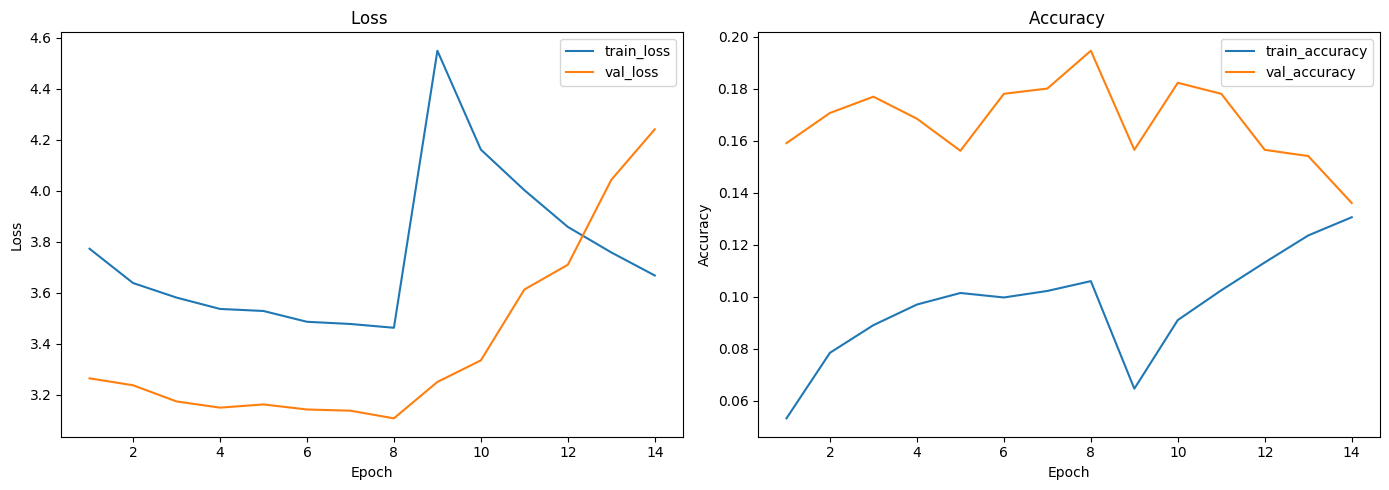


✅ Done! Best model was saved during training to:
→ artifacts/checkpoints_20250907-013727
You can load it later with:
  tf.keras.models.load_model('path/to/best_model.keras')


In [ ]:
# ----------------------------------------
# ✅ BLOCK 7: TWO-STAGE TRAINING
# ----------------------------------------

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

# ✅ Confirm all necessary global variables exist
required_globals = ['train_ds', 'val_ds', 'NUM_CLASSES', 'IMG_SIZE', 'class_weights', 'callbacks']
missing = [g for g in required_globals if g not in globals()]
if missing:
    raise RuntimeError(f"Missing required globals: {missing}. Run earlier blocks.")

# ----------------------------------------
# 🔧 Define hyperparameters for both stages
# ----------------------------------------

STAGE1_EPOCHS = 8              # Train classifier head only
STAGE2_EPOCHS = 6              # Fine-tune base model
STAGE1_LR = 1e-3
STAGE2_LR = 1e-5
UNFREEZE_LAST_N_LAYERS = 50    # Unfreeze top 50 layers for fine-tuning
DROP_OUT_HEAD = 0.4
TOTAL_EPOCHS = STAGE1_EPOCHS + STAGE2_EPOCHS

# ----------------------------------------
# 🔨 Build model with frozen base (Stage 1)
# ----------------------------------------

model, base_model = build_model(base_trainable=False, dropout_rate=DROP_OUT_HEAD)
print("✅ Model compiled for Stage 1 — training head only.")

# ----------------------------------------
# 📶 Stage 1: Train head only
# ----------------------------------------

print(f"\n🚀 Stage 1 training: {STAGE1_EPOCHS} epochs, LR = {STAGE1_LR}")
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=STAGE1_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ----------------------------------------
# 🔓 Utility: Unfreeze last N layers of the base model
# ----------------------------------------

def unfreeze_last_n(base_model, n):
    """
    Unfreezes the last `n` layers of the base model (for fine-tuning).
    """
    if base_model is None:
        raise ValueError("base_model is None")

    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers first

    if n > 0:
        for layer in base_model.layers[-n:]:
            layer.trainable = True

    total_trainable = sum([layer.trainable for layer in base_model.layers])
    print(f"✅ Unfroze top {n} layers → Total trainable layers in base: {total_trainable}")
    return total_trainable

# 🔓 Unfreeze layers before Stage 2
n_unfrozen = unfreeze_last_n(base_model, UNFREEZE_LAST_N_LAYERS)

# ----------------------------------------
# 🛠️ Recompile model with a lower LR for fine-tuning
# ----------------------------------------

fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=STAGE2_LR)
model.compile(
    optimizer=fine_tune_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top-3-accuracy")
    ]
)

print("✅ Model recompiled for Stage 2 — fine-tuning top layers.")

# ----------------------------------------
# 📶 Stage 2: Fine-tune last N layers
# ----------------------------------------

print(f"\n🎯 Stage 2 fine-tuning: {STAGE2_EPOCHS} epochs, LR = {STAGE2_LR}")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=STAGE1_EPOCHS,  # Resume training
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ----------------------------------------
# 🔗 Combine both training histories
# ----------------------------------------

def combine_histories(h1, h2):
    """
    Merges two Keras History objects (for plotting all epochs together).
    """
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history.get(key, [])
    return combined

combined_history = combine_histories(history_stage1, history_stage2)

# 💾 Save training history to file
os.makedirs("artifacts", exist_ok=True)
hist_path = f"artifacts/training_history_{time.strftime('%Y%m%d-%H%M%S')}.json"
with open(hist_path, "w") as f:
    json.dump(combined_history, f)

print(f"\n💾 Saved training history to: {hist_path}")

# ----------------------------------------
# 📈 Plot training curves (loss & accuracy)
# ----------------------------------------

def plot_history(history_dict, title_suffix=""):
    """
    Plots training and validation accuracy/loss over all epochs.
    """
    epochs = range(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], label='train_loss')
    plt.plot(epochs, history_dict.get('val_loss', []), label='val_loss')
    plt.title('Loss ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict.get('accuracy', []), label='train_accuracy')
    plt.plot(epochs, history_dict.get('val_accuracy', []), label='val_accuracy')
    plt.title('Accuracy ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\n📊 Final Training Curves:")
plot_history(combined_history)

# ----------------------------------------
# ✅ Final Notes
# ----------------------------------------

print("\n✅ Done! Best model was saved during training to:")
print("→", checkpoint_dir)
print("You can load it later with:")
print("  tf.keras.models.load_model('path/to/best_model.keras')")

✅ Loading best model from: artifacts/checkpoints_20250907-013727/best_model.keras

🧪 Predicting on test set...
170/170 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step

📋 Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00        58
                            Apple___Black_rot       0.00      0.00      0.00        65
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        25
                              Apple___healthy       0.09      0.02      0.03       159
                          Blueberry___healthy       0.34      0.36      0.35       133
                             Cherry___healthy       0.06      0.01      0.02        90
                      Cherry___Powdery_mildew       0.00      0.00      0.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        56
                           Corn___C

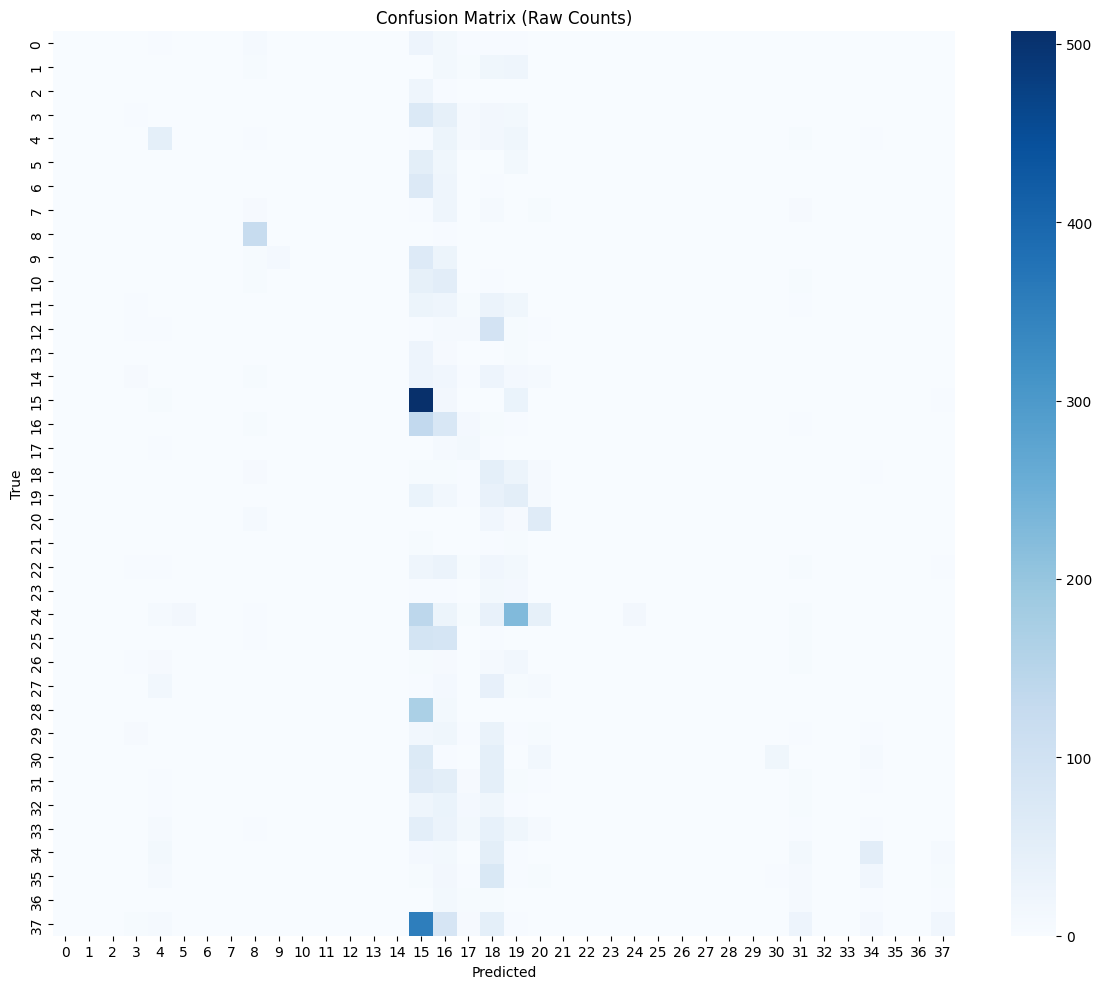

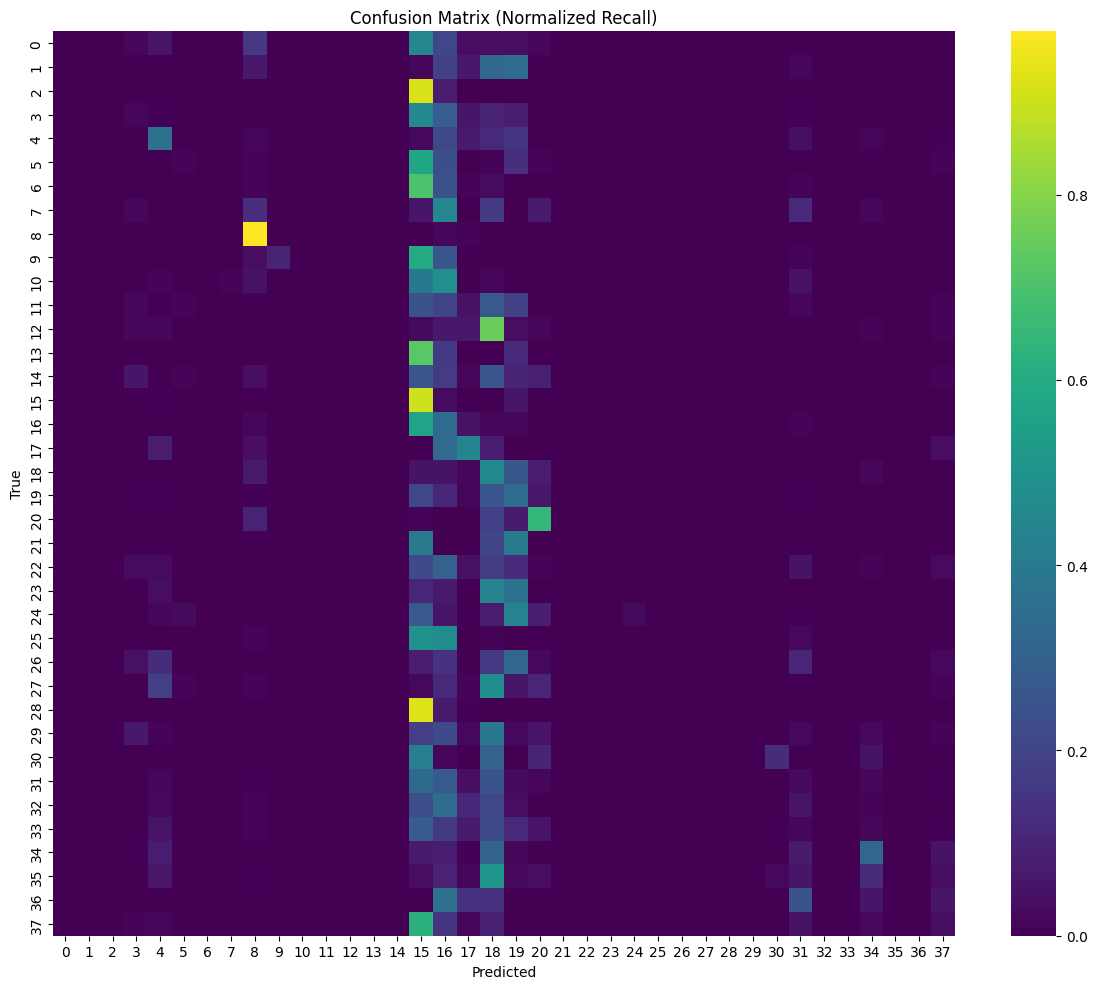

💾 Saved confusion matrix images.

📊 Summary:
Macro F1       : 0.0911
Micro F1       : 0.1952
Macro Precision: 0.1518
Macro Recall   : 0.1346
Overall Accuracy: 0.1952
💾 Saved summary metrics.
Top-3 Accuracy: 0.3969

❌ Found 4370 misclassified samples.


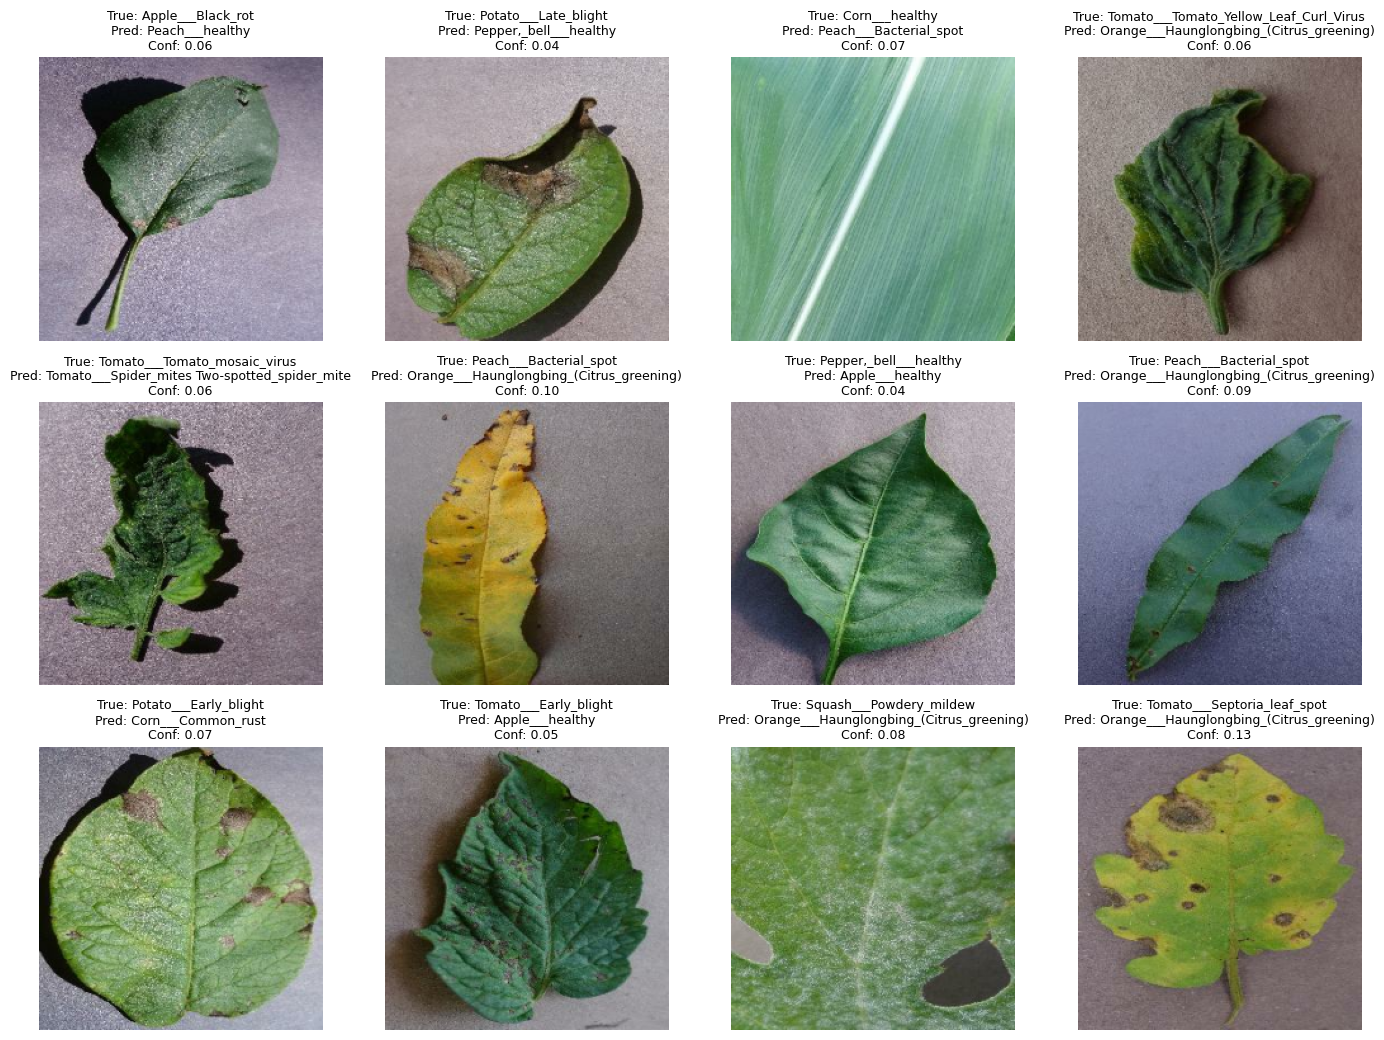

💾 Saved misclassified samples plot.

📉 Classes with lowest recall:
Apple___Apple_scab                       → recall = 0.000, support = 58.0
Apple___Black_rot                        → recall = 0.000, support = 65.0
Apple___Cedar_apple_rust                 → recall = 0.000, support = 25.0
Cherry___Powdery_mildew                  → recall = 0.000, support = 100.0
Corn___Cercospora_leaf_spot Gray_leaf_spot → recall = 0.000, support = 56.0
Corn___Northern_Leaf_Blight              → recall = 0.000, support = 112.0
Grape___Black_rot                        → recall = 0.000, support = 112.0
Grape___Esca_(Black_Measles)             → recall = 0.000, support = 126.0
Grape___healthy                          → recall = 0.000, support = 36.0
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) → recall = 0.000, support = 105.0


In [ ]:
# ----------------------------------------
# ✅ BLOCK 8: EVALUATION & ERROR ANALYSIS
# ----------------------------------------

# ✅ Required imports
import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow.keras.models import load_model

# ✅ Ensure test_ds and class_names exist
required = ['test_ds', 'class_names']
missing = [r for r in required if r not in globals()]
if missing:
    raise RuntimeError(f"Missing required globals: {missing}. Ensure test_ds and class_names are created.")

NUM_CLASSES = len(class_names)
os.makedirs("artifacts/eval", exist_ok=True)

# ----------------------------------------
# 🔄 Load best model from checkpoint
# ----------------------------------------

# Check if a best_model exists
best_model_paths = sorted(glob.glob("artifacts/checkpoints_*/*best_model.keras"), reverse=True)
if best_model_paths:
    best_path = best_model_paths[0]
    print("✅ Loading best model from:", best_path)
    try:
        eval_model = load_model(best_path)
    except Exception as e:
        print("⚠️ Load failed, using in-memory model. Error:", e)
        eval_model = model
else:
    print("⚠️ No checkpoint found — using current model.")
    eval_model = model

# ----------------------------------------
# 🔍 Run predictions on test set
# ----------------------------------------

print("\n🧪 Predicting on test set...")
probs = eval_model.predict(test_ds, verbose=1)     # (N, NUM_CLASSES)
y_pred = np.argmax(probs, axis=1)

# Recreate y_true labels in same order
y_true_list = []
for _, labels in test_ds:
    y_true_list.append(labels.numpy())
y_true = np.concatenate(y_true_list)

# ✅ Ensure both arrays align
assert len(y_true) == len(y_pred), "Mismatch in prediction count."

# ----------------------------------------
# 📋 Classification Report
# ----------------------------------------

print("\n📋 Classification Report:")
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
)
report_str = classification_report(
    y_true, y_pred, target_names=class_names, zero_division=0
)
print(report_str)

# 💾 Save reports
with open("artifacts/eval/classification_report.json", "w") as f:
    json.dump(report_dict, f, indent=2)

# Convert to CSV-style report
rows = []
for label, metrics_dict in report_dict.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    rows.append({
        "class": label,
        "precision": metrics_dict.get("precision", 0.0),
        "recall": metrics_dict.get("recall", 0.0),
        "f1-score": metrics_dict.get("f1-score", 0.0),
        "support": int(metrics_dict.get("support", 0))
    })

df_report = pd.DataFrame(rows).sort_values("support", ascending=False)
df_report.to_csv("artifacts/eval/classification_report_by_class.csv", index=False)
print("💾 Saved classification report CSV.")

# ----------------------------------------
# 📊 Confusion Matrix
# ----------------------------------------

cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

# Save raw + normalized confusion matrix
np.save("artifacts/eval/confusion_matrix_raw.npy", cm)
np.save("artifacts/eval/confusion_matrix_norm.npy", cm_norm)

# 🔥 Plot confusion matrix (raw)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("artifacts/eval/confusion_matrix_raw.png")
plt.show()

# 🔥 Plot normalized matrix (recall per class)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, cmap="viridis", fmt=".2f")
plt.title("Confusion Matrix (Normalized Recall)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("artifacts/eval/confusion_matrix_norm.png")
plt.show()

print("💾 Saved confusion matrix images.")

# ----------------------------------------
# 📈 Summary Metrics
# ----------------------------------------

macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
accuracy = report_dict.get('accuracy', 0.0)

print("\n📊 Summary:")
print(f"Macro F1       : {macro_f1:.4f}")
print(f"Micro F1       : {micro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

summary = {
    "macro_f1": float(macro_f1),
    "micro_f1": float(micro_f1),
    "macro_precision": float(macro_precision),
    "macro_recall": float(macro_recall),
    "accuracy": float(accuracy)
}
with open("artifacts/eval/summary_metrics.json", "w") as f:
    json.dump(summary, f, indent=2)
print("💾 Saved summary metrics.")

# ----------------------------------------
# 🧠 Top-K Accuracy (Top-3)
# ----------------------------------------

def compute_top_k_accuracy(probs, y_true, k=3):
    """
    Computes top-k accuracy — useful when top-1 fails but top guesses still include correct class.
    """
    topk_preds = np.argsort(probs, axis=1)[:, -k:]
    hits = [y_true[i] in topk_preds[i] for i in range(len(y_true))]
    return np.mean(hits)

top3 = compute_top_k_accuracy(probs, y_true, k=3)
print(f"Top-3 Accuracy: {top3:.4f}")

# ----------------------------------------
# 🖼️ Show misclassified images
# ----------------------------------------

def denormalize_image(img_tensor):
    """ Convert normalized image to uint8 for display """
    img = np.clip(img_tensor * 255.0, 0, 255).astype(np.uint8)
    return img

N_SHOW = 12
mis_idx = np.where(y_true != y_pred)[0]
print(f"\n❌ Found {len(mis_idx)} misclassified samples.")

if len(mis_idx) == 0:
    print("🎉 No misclassifications found!")
else:
    to_show_idx = set(mis_idx[:N_SHOW])
    collected = []
    curr_index = 0

    for xb, yb in test_ds:
        xb_np, yb_np = xb.numpy(), yb.numpy()
        batch_size = xb_np.shape[0]
        for i in range(batch_size):
            if curr_index in to_show_idx:
                collected.append({
                    "index": curr_index,
                    "image": xb_np[i],
                    "y_true": int(yb_np[i]),
                    "y_pred": int(y_pred[curr_index]),
                    "prob": float(probs[curr_index][y_pred[curr_index]])
                })
                if len(collected) >= len(to_show_idx):
                    break
            curr_index += 1
        if len(collected) >= len(to_show_idx):
            break

    # Plot misclassified samples
    cols = 4
    rows = int(np.ceil(len(collected) / cols))
    plt.figure(figsize=(cols * 3.5, rows * 3.5))
    for i, item in enumerate(collected):
        ax = plt.subplot(rows, cols, i + 1)
        img = denormalize_image(item["image"])
        plt.imshow(img)
        title = f"True: {class_names[item['y_true']]}\nPred: {class_names[item['y_pred']]}\nConf: {item['prob']:.2f}"
        ax.set_title(title, fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig("artifacts/eval/misclassified_samples.png", bbox_inches='tight', dpi=150)
    plt.show()

    print("💾 Saved misclassified samples plot.")

# ----------------------------------------
# 🐌 Show classes with lowest recall
# ----------------------------------------

class_recalls = [
    (c, report_dict[c]['recall'], report_dict[c]['support'])
    for c in class_names
]
class_recalls_sorted = sorted(class_recalls, key=lambda x: x[1])

print("\n📉 Classes with lowest recall:")
for c, recall_val, support in class_recalls_sorted[:10]:
    print(f"{c:40s} → recall = {recall_val:.3f}, support = {support}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


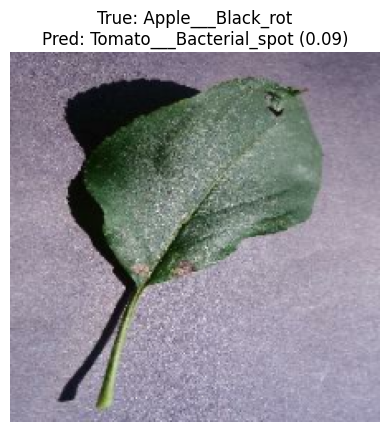

In [ ]:
# ----------------------------------------
# ✅ BLOCK 9: PREDICT ON A NEW IMAGE (FROM PLANTVILLAGE)
# ----------------------------------------

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# ✅ Function to preprocess a single image (same as training pipeline)
def preprocess_single_image(image, target_size=IMG_SIZE):
    """
    Resize and scale image to [-1, 1] to match EfficientNetB0 preprocessing.
    Assumes image is in [0, 255] range (uint8).
    """
    image = tf.image.resize(image, [target_size, target_size])
    image = tf.cast(image, tf.float32) / 255.0       # Normalize to [0,1]
    image = image * 2.0 - 1.0                         # Normalize to [-1,1]
    return image

# ✅ Function to predict a label for one image
def predict_image(image_tensor, model, class_names):
    """
    - image_tensor: Tensor shape (H, W, C)
    - model: trained Keras model
    - class_names: list of label names
    """
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dim → (1, H, W, C)
    probs = model.predict(image_tensor)[0]               # Predict → shape (NUM_CLASSES,)
    predicted_index = tf.argmax(probs).numpy()
    confidence = probs[predicted_index]
    predicted_class = class_names[predicted_index]
    return predicted_class, confidence, probs

# ✅ Pick a test image from PlantVillage test set
# NOTE: test_ds is a batched dataset → we unbatch it to get single images
for image, label in test_ds.unbatch().take(1):  # Just take 1 sample
    sample_image = image
    sample_label_index = label.numpy()
    sample_label_name = class_names[sample_label_index]

# ✅ Preprocess and predict
processed_image = preprocess_single_image(sample_image)
predicted_class, confidence, probs = predict_image(processed_image, eval_model, class_names)

# ✅ Show result
plt.imshow(sample_image.numpy())
plt.title(f"True: {sample_label_name}\nPred: {predicted_class} ({confidence:.2f})")
plt.axis('off')
plt.show()

### The model accuracy is not up to the mark. There are multiple reasons behind it -

a) As PlanVillage covers multiple crop data and disease classes, model is struggling to learn efficiently. Some leaves look similar

b) Some classes ( Plant and Disease ) dominate the dataset leading to class imbalance


### While the model is not fully accurate , this is a a good starting point. In the next set of codes we will use advanced technique to fine tune the model and increase accuracy. Including

a) Using EfficientnetB4 ( Instead of B0) for better feature extraction from the images

b) Run model for higher Epochs

c) Train the model in batches for each plant leaf type